In [7]:
%matplotlib inline
import glob
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import misc
import numpy as np
import cv2


In [8]:
images = glob.glob(os.path.join('..','data', 'samples', '*.jpeg'))
images

['..\\data\\samples\\10_left.jpeg',
 '..\\data\\samples\\10_right.jpeg',
 '..\\data\\samples\\13_left.jpeg',
 '..\\data\\samples\\13_right.jpeg',
 '..\\data\\samples\\15_left.jpeg',
 '..\\data\\samples\\15_right.jpeg',
 '..\\data\\samples\\16_left.jpeg',
 '..\\data\\samples\\16_right.jpeg',
 '..\\data\\samples\\17_left.jpeg',
 '..\\data\\samples\\17_right.jpeg']

In [9]:
def smart_crop(im, threshold=30):
    """
    im = image as np array
    threshold = min pixel value for binary-otsu thresholding
    crops eyes out of each image (removes the black background)
    """
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, threshold, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
    return im[y:y+h,x:x+w]

In [10]:
def preprocess(im, size=(512, 512), threshold=50):
    im = cv2.imread(im)
    im = smart_crop(im, threshold)
    im = smart_resize(im, size)
    return im

In [11]:
def smart_resize(im, size=(512, 512)):
    """
    resize an image while retaining aspect ratio, pad with black background
    """
    h, w, _ = im.shape
    
    if w > h:
        difference = w - h
        top = int((difference/2 + (difference%2)))
        bottom = int(np.ceil(difference/2.))
        left = 0
        right = 0
        im = cv2.copyMakeBorder(im, top, bottom, left, right,cv2.BORDER_CONSTANT)
    if h > w:
        difference = h - w
        top = 0
        bottom = 0
        left = int((difference/2 + (difference%2)))
        right = int(np.ceil(difference/2.))
        im = cv2.copyMakeBorder(im, top, bottom, left, right,cv2.BORDER_CONSTANT)
    im = cv2.resize(im, size)
    return im

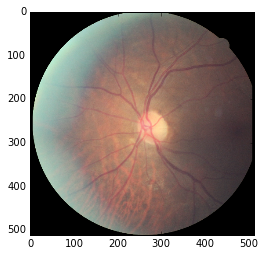

In [12]:
plt.imshow(cv2.cvtColor(preprocess(images[0]), cv2.COLOR_BGR2RGB))

In [13]:
samples = np.array(map(preprocess, images))

In [28]:
samples.shape

(10L, 512L, 512L, 3L)

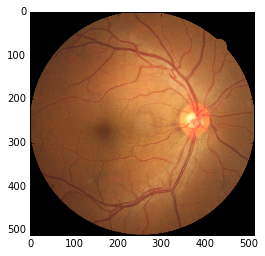

In [29]:
plt.imshow(cv2.cvtColor(samples[9],cv2.COLOR_BGR2RGB))

In [30]:
img = samples[1]

In [31]:
def histogram_equalization(im):
    img_yuv = cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb)
    img_yuv[:,:,0] = cv2.equalizeHist(img[:,:,0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YCR_CB2RGB)

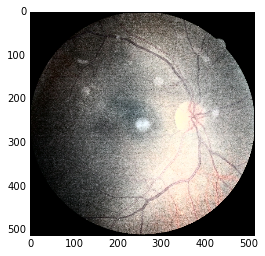

In [32]:
new_img = histogram_equalization(img)
plt.imshow(new_img)

In [33]:
images

['..\\data\\samples\\10_left.jpeg',
 '..\\data\\samples\\10_right.jpeg',
 '..\\data\\samples\\13_left.jpeg',
 '..\\data\\samples\\13_right.jpeg',
 '..\\data\\samples\\15_left.jpeg',
 '..\\data\\samples\\15_right.jpeg',
 '..\\data\\samples\\16_left.jpeg',
 '..\\data\\samples\\16_right.jpeg',
 '..\\data\\samples\\17_left.jpeg',
 '..\\data\\samples\\17_right.jpeg']

In [34]:
class ImageGenerator(object):
    def __init__(self, dirname, ending='*jpeg'):
        self.dirname = dirname
        self.ending = ending
 
    def __iter__(self):
        for image in glob.glob(os.path.join(self.dirname, '*.jpeg')):
            yield image

In [35]:
def generator(directory, ending='*jpeg'):
    for image in glob.glob(os.path.join(directory, ending)):
        yield preprocess(image)

In [36]:
generator = generator(os.path.join('..','data', 'samples'))

In [37]:
import itertools

In [38]:
images = np.array(list(itertools.islice(generator, 0, 5, 1)))

In [39]:
images.shape

(5L, 512L, 512L, 3L)

In [40]:
from multiprocessing import Pool


In [41]:
class PreProcessor:
    
    def smart_crop(self, im, threshold=30):
        """
        Detects and crops around eyes in each image
        im = image as np array
        threshold = min pixel value for binary-otsu thresholding

        """
        imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(imgray, threshold, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(contours[0])
        return im[y:y+h,x:x+w]

    def smart_resize(self, im, size=(512, 512)):
        """
        resize an image while retaining aspect ratio, pad with black background
        im = image as np array
        """
        h, w, _ = im.shape

        if w > h:
            difference = w - h
            top = int((difference/2 + (difference%2)))
            bottom = int(np.ceil(difference/2.))
            left = 0
            right = 0
            im = cv2.copyMakeBorder(im, top, bottom, left, right,cv2.BORDER_CONSTANT)
        if h > w:
            difference = h - w
            top = 0
            bottom = 0
            left = int((difference/2 + (difference%2)))
            right = int(np.ceil(difference/2.))
            im = cv2.copyMakeBorder(im, top, bottom, left, right,cv2.BORDER_CONSTANT)
        im = cv2.resize(im, size)
        return im

    def histogram_equalization(self, im):
        im_yuv = cv2.cvtColor(im, cv2.COLOR_BGR2YUV)
        im_yuv[:,:,0] = cv2.equalizeHist(im[:,:,0])
        return cv2.cvtColor(im_yuv, cv2.COLOR_YUV2RGB)

    def preprocess_img(self, im, size=(512, 512), threshold=50, norm=False):
        im = cv2.imread(im)
        im = self.smart_crop(im, threshold)
        im = self.smart_resize(im, size)
        if norm == True:
            return self.histogram_equalization(im)
        else:
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  
    def preprocess_directory(self, input_dir, output_dir, size=(512, 512), threshold=50, norm=False, parallel=):
        """process all images in input dir and save to output_dir"""
        files = os.listdir(input_dir)
        for f in files:
            inpath = os.path.join(input_dir, f)
            outpath = os.path.join(output_dir, f)
            im = self.preprocess_img(inpath, norm=norm)
            misc.imsave(outpath, im)    

SyntaxError: invalid syntax (<ipython-input-41-b60b08df71ae>, line 54)

In [ ]:
pre = PreProcessor()

In [42]:
images = glob.glob(os.path.join('..','data', 'samples', '*.jpeg'))

In [43]:
pre.preprocess_directory(os.path.join('..','data', 'samples'), os.path.join('..','data', 'processed_samples'))

NameError: name 'pre' is not defined

In [44]:
def y_generator(directory):
    reader = csv.reader(directory)
    for label in reader:
        yield label

In [45]:
import csv
import os

In [46]:
y = y_generator(os.path.join('..', 'data', 'trainLabels.csv'))
    def x_generator(self, directory):
        for image in glob.glob(directory):
            yield image

IndentationError: unexpected indent (<ipython-input-46-01a194f4b93f>, line 2)

In [47]:
import pandas as pd
import numpy as np
import itertools

In [48]:
y = pd.read_csv(os.path.join('..', 'data', 'trainLabels.csv'))


In [49]:
y = y.level.values

In [50]:
len(list(itertools.islice(y, 0, 50000, None)))

35126

In [51]:
class ImageGenerator:
    def __init__(self, X_path=os.path.join("E:", "DR_Data", "Train512"), y_path=os.path.join('data', 'trainLabels.csv')):
        self.X_path = X_path
        self.y_path = y_path

    def x_generator(self, directory):
        for image in glob.glob(directory):
            yield image

    def y(self, directory):
        y = pd.read_csv(directory)
        return y.level.values

    def get_batch(self, batch_size=5):
        x_gen = self.x_generator(self.X_path)
        y = self.y(self.y_path)
        X_batch = list(itertools.islice(x_gen, 0, batch_size, 1))
        y_batch = list(itertools.islice(y, 0, batch_size, 1))
        return X_batch, y_batch

In [52]:
gen = ImageGenerator()

In [53]:
im = cv2.imread(images[0]).shape

In [54]:
def get_sample_matrix(images):
    return np.array([misc.imread(im).astype('float64') for im in images])

In [55]:
test =  np.array(images)

In [56]:
test

array(['..\\data\\samples\\10_left.jpeg',
       '..\\data\\samples\\10_right.jpeg',
       '..\\data\\samples\\13_left.jpeg',
       '..\\data\\samples\\13_right.jpeg',
       '..\\data\\samples\\15_left.jpeg',
       '..\\data\\samples\\15_right.jpeg',
       '..\\data\\samples\\16_left.jpeg',
       '..\\data\\samples\\16_right.jpeg',
       '..\\data\\samples\\17_left.jpeg',
       '..\\data\\samples\\17_right.jpeg'], 
      dtype='|S29')

In [57]:
images = glob.glob(os.path.abspath(os.path.join('E:', 'DR_Data', 'train_512', '*')))

In [61]:
np.random.seed(1337)
sample = np.random.choice(images, 1000)

In [62]:
X = get_sample_matrix(sample)


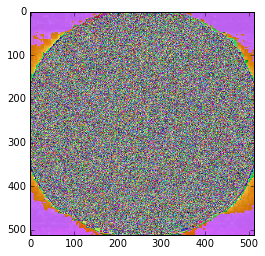

In [60]:
plt.imshow(np.mean(X, axis=0))

In [65]:
mean = np.mean(X, axis=0)

In [66]:
mean.shape

(512L, 512L, 3L)

In [67]:
np.save('mean_image', X)

In [ ]:
X.astype('float64')

In [68]:
X

array([[[[ 176.,  199.,  215.],
         [ 176.,  199.,  215.],
         [ 176.,  199.,  215.],
         ..., 
         [ 176.,  199.,  215.],
         [ 176.,  199.,  215.],
         [ 176.,  199.,  215.]],

        [[ 176.,  199.,  215.],
         [ 176.,  199.,  215.],
         [ 176.,  199.,  215.],
         ..., 
         [ 176.,  199.,  215.],
         [ 176.,  199.,  215.],
         [ 176.,  199.,  215.]],

        [[ 176.,  199.,  215.],
         [ 176.,  199.,  215.],
         [ 176.,  199.,  215.],
         ..., 
         [ 176.,  199.,  215.],
         [ 176.,  199.,  215.],
         [ 176.,  199.,  215.]],

        ..., 
        [[ 176.,  199.,  215.],
         [ 176.,  199.,  215.],
         [ 176.,  199.,  215.],
         ..., 
         [ 176.,  199.,  215.],
         [ 176.,  199.,  215.],
         [ 176.,  199.,  215.]],

        [[ 176.,  199.,  215.],
         [ 176.,  199.,  215.],
         [ 176.,  199.,  215.],
         ..., 
         [ 176.,  199.,  215.],
       

In [101]:
test = cv2.imread(images[9000])

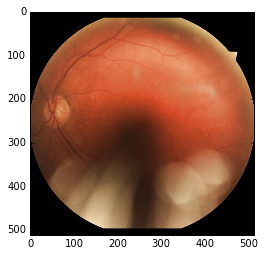

In [97]:
plt.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))

In [98]:
test = cv2.fastNlMeansDenoisingColored(test,None,5,5,7,21)

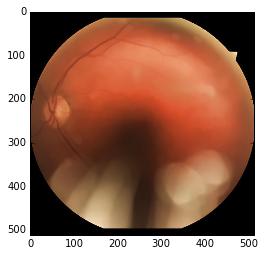

In [99]:
plt.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))

In [100]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 9ADC-B861

 Directory of C:\Users\Austin\code\ds_projects\Retinopathy_Detection\tutorial

08/24/2016  03:06 AM    <DIR>          .
08/24/2016  03:06 AM    <DIR>          ..
08/23/2016  06:25 PM    <DIR>          .ipynb_checkpoints
08/22/2016  01:10 AM            40,967 EDA.ipynb
08/24/2016  03:06 AM           804,188 Further_Preprocessing.ipynb
08/21/2016  02:41 AM            18,888 generators.ipynb
08/24/2016  01:54 AM           430,597 mean.ipynb
08/24/2016  03:00 AM     6,291,456,096 mean_image.npy
08/24/2016  02:48 AM           333,255 Preprocessing_Workflow.ipynb
08/23/2016  08:08 PM       629,145,696 sample_X.npy
08/19/2016  05:17 AM             5,853 Starter_Model.ipynb
               8 File(s)  6,922,235,540 bytes
               3 Dir(s)  309,033,508,864 bytes free


In [127]:
rawr  = misc.imread(images[10002])

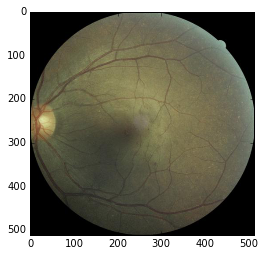

In [128]:
plt.imshow(rawr)

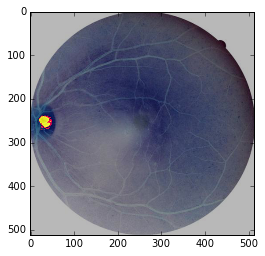

In [129]:
plt.imshow(rawr - np.mean(rawr))